# **데이터 준비**

In [ ]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# 캐글 환경에서 zip파일을 받아 압축을 풀고 폴더에 저장하기
print(os.listdir("../input"))

import zipfile

with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

['dogs-vs-cats']


In [ ]:
# 학습할 때 뜨는 경고문을 무시하기 위해 설정
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 학습을 위한 영상 초기 설정을 변수로 저장
# 영상 크기(128*128), 영상 차원: 3차원
# fast_run(epoch에서 학습 횟수 제한) 
FAST_RUN=False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
# 학습 데이터에서 개는 1, 고양이는 0으로 분류해 정답 레이블 생성
# df에 이미지 이름과 카테고리를 분류해 저장
filenames=os.listdir("../working/train")
categories=[]
for filename in filenames:
    category=filename.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# **데이터 전처리**

In [ ]:
# 컬럼 카데고리를 문자열로 변경
df["category"]=df["category"].replace({0:'cat',1:'dog'})

In [ ]:
# test_size를 20%만큼 나눈 후 인덱스 재정렬
train_df,validate_df=train_test_split(df,test_size=0.2,random_state=42)
train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)

# 학습데이터 및 검증데이터의 형상을 확인하고 batch 크기 설정
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [ ]:
# 학습 데이터 제너레이터 설정
train_datagen=ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator=train_datagen.flow_from_dataframe(
    train_df,
    "../working/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# 검증 데이터 제너레이터 설정
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=validation_datagen.flow_from_dataframe(
    validate_df,
    "../working/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
# 샘플 데이터 확인
example_df=train_df.sample(n=1).reset_index(drop=True)
example_generator=train_datagen.flow_from_dataframe(
    example_df,
    "../working/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
)

Found 1 validated image filenames belonging to 1 classes.


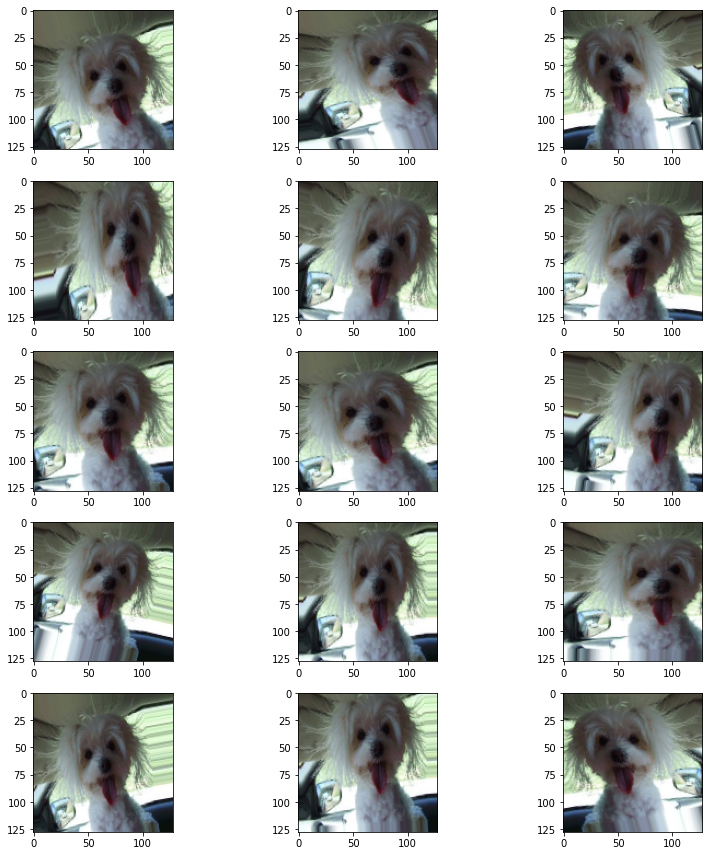

In [ ]:
# 이미지 확인
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for X_batch, Y_batch in example_generator:
        image=X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# **모델 생성**

In [ ]:
# 모델링
model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)       

In [ ]:
# Earlystop을 설정해 과적합 방지
earlystop=EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',
                                          patience=2,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.00001)

In [ ]:
callbacks=[earlystop,learning_rate_reduction]

# **모델 학습**

In [ ]:
# 모델 학습
epochs=3 if FAST_RUN else 50
history=model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

# 학습시킨 모델 저장
model.save_weights("model.h5")

Epoch 1/50
1333/1333 [==============================] - 163s 120ms/step - loss: 0.7532 - accuracy: 0.6312 - val_loss: 0.6538 - val_accuracy: 0.6695
Epoch 2/50
1333/1333 [==============================] - 158s 118ms/step - loss: 0.5583 - accuracy: 0.7222 - val_loss: 0.6008 - val_accuracy: 0.6735
Epoch 3/50
1333/1333 [==============================] - 158s 119ms/step - loss: 0.5206 - accuracy: 0.7486 - val_loss: 0.4896 - val_accuracy: 0.7694
Epoch 4/50
1333/1333 [==============================] - 158s 118ms/step - loss: 0.4760 - accuracy: 0.7743 - val_loss: 0.4360 - val_accuracy: 0.7990
Epoch 5/50
1333/1333 [==============================] - 157s 118ms/step - loss: 0.4475 - accuracy: 0.7939 - val_loss: 0.5333 - val_accuracy: 0.7674
Epoch 6/50
1333/1333 [==============================] - 163s 122ms/step - loss: 0.4274 - accuracy: 0.8086 - val_loss: 0.4311 - val_accuracy: 0.8000
Epoch 7/50
1333/1333 [==============================] - 163s 122ms/step - loss: 0.4145 - accuracy: 0.8142 - val_

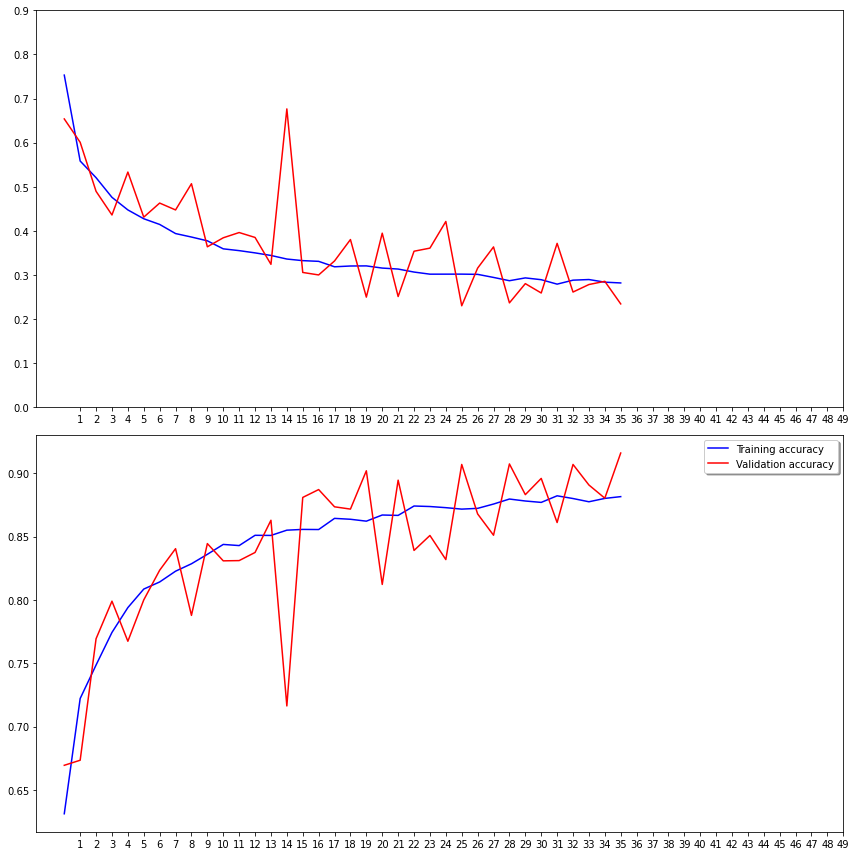

In [ ]:
# 학습 결과를 그래프를 통해 확인
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,12))
ax1.plot(history.history['loss'],color='b',label="Training loss")
ax1.plot(history.history['val_loss'],color='r',label="Validation loss")
ax1.set_xticks(np.arange(1,epochs,1))
ax1.set_yticks(np.arange(0,1,0.1))

ax2.plot(history.history['accuracy'],color='b',label="Training accuracy")
ax2.plot(history.history['val_accuracy'],color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1,epochs,1))

legend=plt.legend(loc='best',shadow=True)
plt.tight_layout()
plt.show()